# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'data'

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# 3. Load Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 662 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

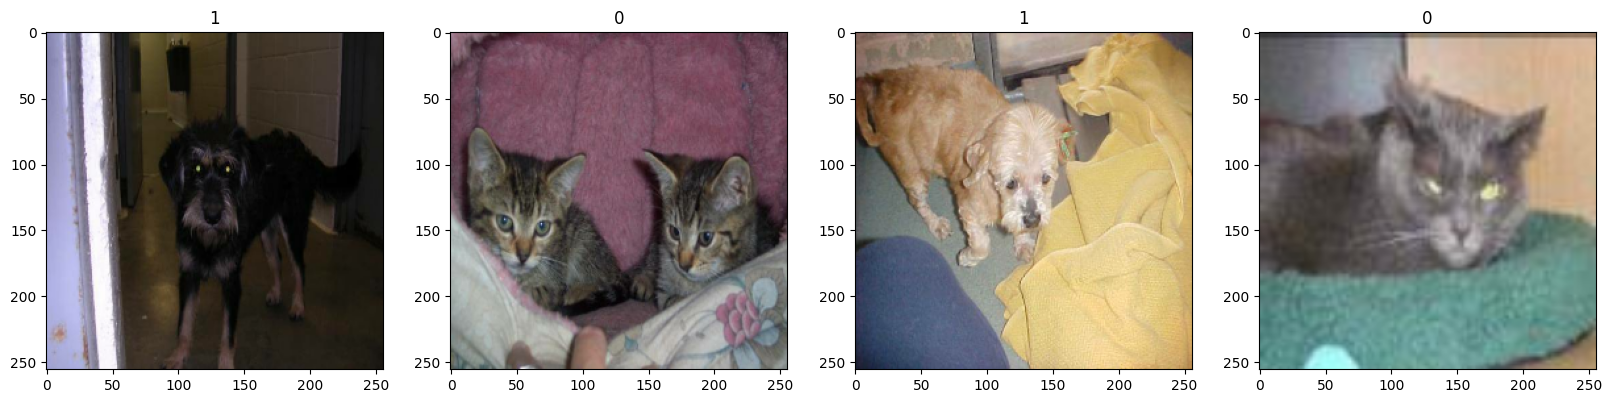

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [157]:
data.shape

AttributeError: '_PrefetchDataset' object has no attribute 'shape'

In [ ]:
data.as_numpy_iterator().next()

(array([[[[0.7992338 , 0.85068136, 0.810064  ],
          [0.79967064, 0.8517693 , 0.80140764],
          [0.8075152 , 0.8556052 , 0.79663277],
          ...,
          [0.4136106 , 0.41678154, 0.3759804 ],
          [0.4038986 , 0.41174173, 0.36860448],
          [0.3941866 , 0.40548408, 0.36234683]],
 
         [[0.82380515, 0.8715755 , 0.8255608 ],
          [0.820578  , 0.8672794 , 0.81700873],
          [0.82212263, 0.86551696, 0.8059428 ],
          ...,
          [0.4216801 , 0.42485106, 0.3840499 ],
          [0.41212213, 0.41996527, 0.376828  ],
          [0.40358457, 0.41488203, 0.37174478]],
 
         [[0.8393689 , 0.88487285, 0.8341404 ],
          [0.8264927 , 0.8711508 , 0.81624883],
          [0.8210483 , 0.8641856 , 0.80461144],
          ...,
          [0.42978707, 0.42978707, 0.3874617 ],
          [0.42188945, 0.42493108, 0.38108492],
          [0.41879594, 0.42352942, 0.37883732]],
 
         ...,
 
         [[0.73756605, 0.7218798 , 0.67855734],
          [0.67769

# 5. Split Data

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [ ]:
print(train_size+val_size+test_size)
len(data)

21


21

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(256, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 16)       

# 7. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
14/14 [==============================] - 47s 3s/step - loss: 0.7143 - accuracy: 0.5424 - val_loss: 0.6843 - val_accuracy: 0.6687
Epoch 2/20
14/14 [==============================] - 30s 2s/step - loss: 0.6676 - accuracy: 0.6429 - val_loss: 0.6214 - val_accuracy: 0.6313
Epoch 3/20
14/14 [==============================] - 30s 2s/step - loss: 0.6219 - accuracy: 0.6116 - val_loss: 0.5956 - val_accuracy: 0.7500
Epoch 4/20
14/14 [==============================] - 29s 2s/step - loss: 0.5787 - accuracy: 0.7232 - val_loss: 0.6367 - val_accuracy: 0.6313
Epoch 5/20
14/14 [==============================] - 29s 2s/step - loss: 0.5291 - accuracy: 0.7143 - val_loss: 0.5312 - val_accuracy: 0.7250
Epoch 6/20
14/14 [==============================] - 29s 2s/step - loss: 0.4437 - accuracy: 0.8170 - val_loss: 0.4857 - val_accuracy: 0.8125
Epoch 7/20
14/14 [==============================] - 36s 3s/step - loss: 0.3483 - accuracy: 0.8683 - val_loss: 0.3542 - val_accuracy: 0.8313
Epoch 8/20
14/14 [==

# 8. Plot Performance

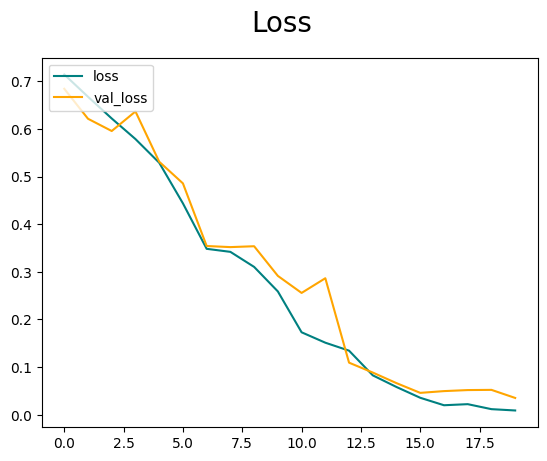

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

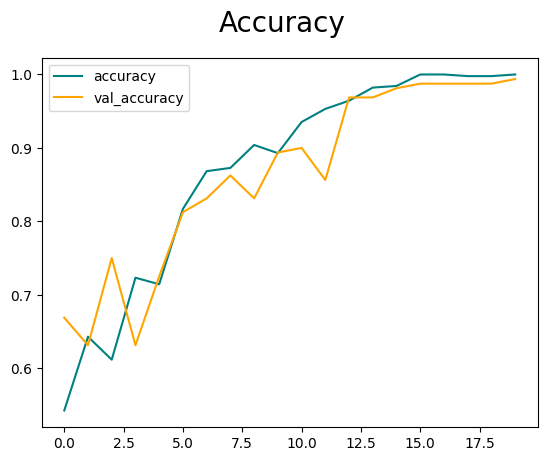

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 388ms/step


In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [ ]:
import cv2

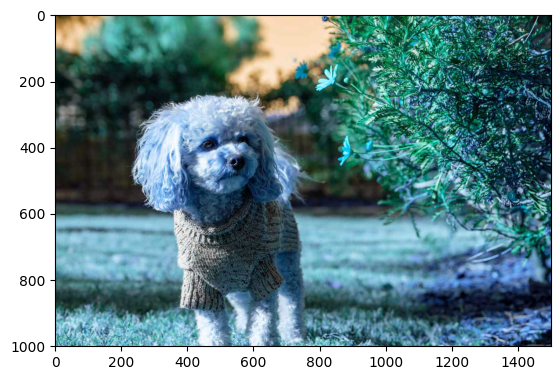

In [ ]:
img = cv2.imread('dog.jpg')
plt.imshow(img)
plt.show()

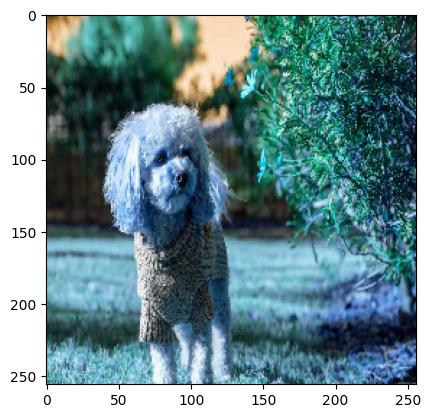

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 46ms/step


In [ ]:
yhat

array([[0.8915713]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is dog')
else:
    print(f'Predicted class is cat')

Predicted class is dog


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
